# Lending Club Analysis

Freddie(Haojie) Chen

03/11/2022

# Relevant Packages

In [1]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import math
import warnings
from EDA import *

#geo package
from __future__ import print_function
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("max_rows",200)
pd.set_option('display.float_format',lambda x : '%.2f' % x)
warnings.filterwarnings('ignore')

In [2]:
#set the maximum missing rate for all the features
null_rate_cutoff_value=0.5
#set the nuber of bucket when classifying feature
bucket_number=10
#set the maximum number of buckets. When the number of bucket exceed the limit, it will get the top n most frequent categories.
bucket_limit=50

# Global Variable

In [3]:
#set the maximum missing rate for all the features
null_rate_cutoff_value=0.5
#set the nuber of bucket when classifying feature
bucket_number=10
#set the maximum number of buckets. When the number of bucket exceed the limit, it will get the top n most frequent categories.
bucket_limit=50

# 1. Load File and Preview Data

From the preview of data we can see that some features have very high percent of missing rates. We need to set a missing rate cutoff value and drop the features whose missing rate is higher than the cutoff value.

In the perspective of risk management, default behavior is the result we need to look into. Therefore, in the following analysis, I will set the loan_status as target variable and try to use EDA to find its influencing factors.

In [4]:
# load File
eda = EDA("accepted_2007_to_2018Q4.csv",bucket_number,bucket_limit)

In [5]:
# Preview Data
eda.data_preview().head(50)

,feature,dtypes,Null_Rate(%),Feature_Data_Example,count,mean,std,min,25%,50%,75%,max
0,id,object,0.00,68407277,nan,nan,nan,nan,nan,nan,nan,nan
28,fico_range_high,float64,0.00,679.00,2260668.00,702.59,33.01,614.00,679.00,694.00,719.00,850.00
128,hardship_flag,object,0.00,N,nan,nan,nan,nan,nan,nan,nan,nan
34,revol_bal,float64,0.00,2765.00,2260668.00,16658.46,22948.31,0.00,5950.00,11324.00,20246.00,2904836.00
37,initial_list_status,object,0.00,w,nan,nan,nan,nan,nan,nan,nan,nan
38,out_prncp,float64,0.00,0.00,2260668.00,4206.89,7343.24,0.00,0.00,0.00,6149.94,40000.00
39,out_prncp_inv,float64,0.00,0.00,2260668.00,4205.97,7342.33,0.00,0.00,0.00,6146.31,40000.00
40,total_pymnt,float64,0.00,4421.72,2260668.00,12082.56,9901.38,0.00,4546.46,9329.72,16940.87,63296.88
41,total_pymnt_inv,float64,0.00,4421.72,2260668.00,12064.39,9896.99,0.00,4531.80,9309.67,16916.71,63296.88
42,total_rec_prncp,float64,0.00,3600.00,2260668.00,9505.77,8321.85,0.00,3000.00,7000.00,13899.10,40000.00


# 2. Analysis of Target Variable: Loan_status

In [6]:
# Statistics of loan status
loan_status_statistics = eda.analysis_pivot(index=["loan_status"], 
                                            columns=None, 
                                            values=["id"], 
                                            aggfunc=["count"])
loan_status_statistics

,count
,id
loan_status,
Charged Off,268559
Current,878317
Default,40
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,1076751
In Grace Period,8436
Late (16-30 days),4349


We only focus on the closed cases, so we will only choose the data whose loan_status equals to 'Fully Paid' or 'Charged Off'.

The data volume of 'Default', 'Does not meet the credit policy. Status:Charged Off', and 'Does not meet the credit policy. Status:Fully Paid' are very small, so we drop them in the following analysis.

In [7]:
# choose the data whose loan_status equals to 'Fully Paid' or 'Charged Off'.
eda.data = eda.data[
    (eda.data["loan_status"] == "Fully Paid")
    | (eda.data["loan_status"] == "Charged Off")
]

In [8]:
loan_status_statistics_settled = eda.analysis_pivot(index=["loan_status"], 
                                                    columns=None, 
                                                    values=["id"], 
                                                    aggfunc=["count"]
                                                   )
loan_status_statistics_settled.loc[
    :, ("Calculate Field", "proportion")
] = loan_status_statistics_settled.loc[:, ("count", "id")] / sum(
    loan_status_statistics_settled.loc[:, ("count", "id")]
)
loan_status_statistics_settled

,count,Calculate Field
,id,proportion
loan_status,,
Charged Off,268559,0.20
Fully Paid,1076751,0.80


The over all default rate is 20%

                  count            Calculate Field
                     id                         id
loan_status Charged Off Fully Paid    Default Rate
issue_yr                                          
2007                 45        206            0.18
2008                247       1315            0.16
2009                594       4122            0.13
2010               1487      10049            0.13
2011               3297      18424            0.15
2012               8644      44723            0.16
2013              21024     113780            0.16
2014              41161     181941            0.18
2015              75803     299742            0.20
2016              68242     224853            0.23
2017              39148     130152            0.23
2018               8867      47444            0.16


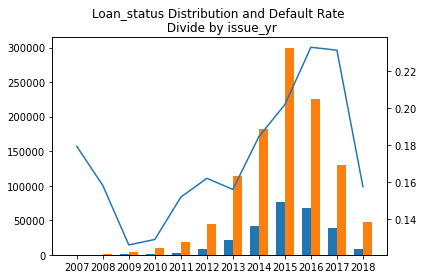

In [9]:
# Temporal distribution of loan status
eda.data['issue_yr']=eda.data['issue_d'].map(str).str.split("-",1).map(lambda x:x[1] if len(x)>1 else None)
feature='issue_yr'
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid")
print(pivot)
plot.show()

# 3.Data Cleaning

I drop the feature whose missing rate is more than the null_rate_cutoff_value. [see Global Variable]

After the data cleaning, the feature number decrease from 151 to 94.

In [10]:
# caculate missing rate for updated dataset
data_preview_updated=eda.data_preview()
eda.data.shape

(1345310, 152)

In [11]:
eda.data = eda.data[list(data_preview_updated[data_preview_updated['Null_Rate(%)']
                                              < null_rate_cutoff_value * 100]['feature'].values)]
eda.data.shape


(1345310, 94)

# 4.Feature Selection

## 4.1.Information Value

Information value is a useful technique to select important variables. It helps to rank variables on the basis of their importance.

If the IV value is less that 0.02, it means the feature is not useful.

If the IV value is more than 0.5, it means the feature is too much useful which is suspecious.

So we will consider the features whose iv value is between 0.02 and 0.5.

In [12]:
#calculate Infornation Value for all Variable
eda.iv_table=pd.DataFrame(columns=['feature','dtype','iv'])

for feature in eda.data.columns.values:
    iv=eda.analysis_iv(feature,"loan_status","id","Charged Off",'Fully Paid')
    eda.iv_table=eda.iv_table.append(iv,ignore_index=True)


In [13]:
eda.iv_table.loc[(eda.iv_table['iv'].isna()),'iv']=math.inf
iv_target=eda.iv_table[(eda.iv_table['iv'].map(type)==float)]
iv_target=iv_target[(iv_target['iv']>0.01)&(iv_target['iv']<0.6)].sort_values(by='iv',ascending=False)
iv_target

,feature,dtype,iv
35,sub_grade,object,0.50
50,last_credit_pull_d_bucket,object,0.49
34,grade,object,0.46
32,int_rate,float64,0.45
13,total_rec_late_fee,float64,0.21
30,term,object,0.17
26,fico_range_low,float64,0.12
12,fico_range_high,float64,0.12
53,dti,float64,0.07
56,last_pymnt_d_bucket,object,0.07


In [14]:
#check the features that the model did not cover
eda.iv_table[(eda.iv_table['iv'].map(type)!=float)].sort_values(by='iv',ascending=False)

,feature,dtype,iv
39,loan_status,object,Target Variable
0,id,object,Error
6,out_prncp,float64,Error
7,out_prncp_inv,float64,Error
18,policy_code,float64,Error


"id", "policy_code" are irevelant features with target variable

"out_prncp", "out_prncp_inv" can cause data leakage

So we do not need to recalculate these variable

# 5.EDA

## 5.1.Discrete Variables

### 5.1.1.grade & sub_grade

"grade" and "sub_grade" are highly correlated, so they have the same influence on the defalut rate.

Higher grade loan is less likely to default.

                  count            Calculate Field
                     id                         id
loan_status Charged Off Fully Paid    Default Rate
grade                                             
A                 14201     220889            0.06
B                 52569     340172            0.13
C                 85649     296037            0.22
D                 61054     139899            0.30
E                 36035      57615            0.38
F                 14491      17567            0.45
G                  4560       4572            0.50


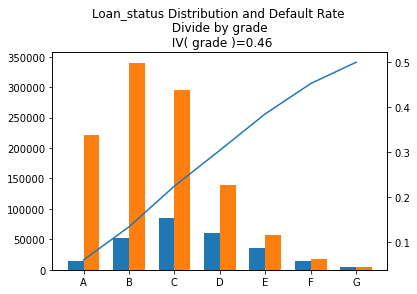

In [15]:
feature='grade'
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid")
print(pivot)
plot.show()

                  count            Calculate Field
                     id                         id
loan_status Charged Off Fully Paid    Default Rate
sub_grade                                         
A1                 1408      42270            0.03
A2                 1734      35444            0.05
A3                 2093      35903            0.06
A4                 3587      48648            0.07
A5                 5379      58624            0.08
B1                 7415      63738            0.10
B2                 8409      65615            0.11
B3                10624      71203            0.13
B4                12336      70863            0.15
B5                13785      68753            0.17
C1                16230      69264            0.19
C2                16412      62801            0.21
C3                16892      58106            0.23
C4                18546      55875            0.25
C5                17569      49991            0.26
D1                14270      37

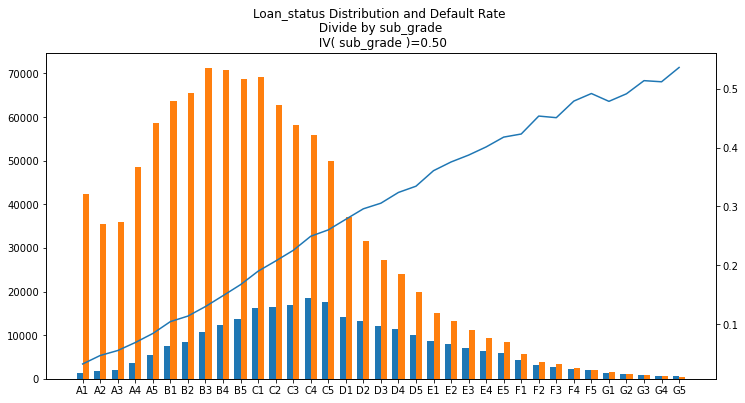

In [16]:
feature='sub_grade'
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",figsize=(12,6))
print(pivot)
plot.show()

### 5.1.2.term

There are two option of terms in lending club: "36 months" and "60 months".

The default rate of "60 months" is two times of "36 months". The longer the repayment period, the higher the probability of default

                  count            Calculate Field
                     id                         id
loan_status Charged Off Fully Paid    Default Rate
term                                              
 36 months       163252     857491            0.16
 60 months       105307     219260            0.32


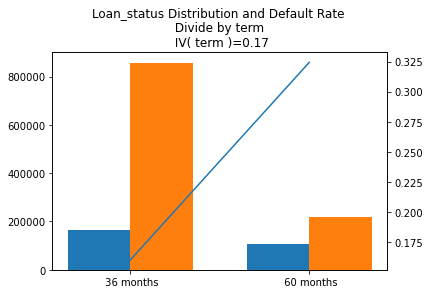

In [17]:
feature="term"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid")
print(pivot)
plot.show()

### 5.1.3.verification_status

Verification status indicates that whether the income of borrower is verified.

Verified borrower are more likely to default.

                          count            Calculate Field
                             id                         id
loan_status         Charged Off Fully Paid    Default Rate
verification_status                                       
Not Verified              59535     346166            0.15
Source Verified          109232     412041            0.21
Verified                  99792     318544            0.24


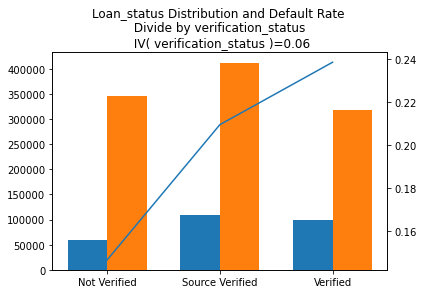

In [18]:
feature="verification_status"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid")
print(pivot)
plot.show()

## 5.1.4.home_ownership

There are three main type of home ownership:'MORTGAGE','OWN',and 'RENT'.

The default rate of borrowers with the home ownership of mortgage is the lowest(17%).

                     count            Calculate Field
                        id                         id
loan_status    Charged Off Fully Paid    Default Rate
home_ownership                                       
MORTGAGE            114531     551048            0.17
OWN                  29864     114968            0.21
RENT                124074     410347            0.23


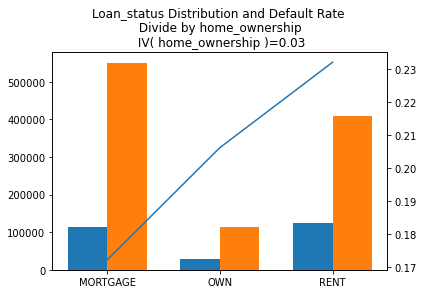

In [19]:
my_type = pd.CategoricalDtype(
    categories=['MORTGAGE','OWN','RENT']
    ,ordered=True)
eda.data["home_ownership"]=eda.data["home_ownership"].astype(my_type)

feature="home_ownership"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid")
print(pivot)
plot.show()

## 5.1.5.purpose

Borrowers with purpose of small business has the highest default rate(30%).

                         count            Calculate Field
                            id                         id
loan_status        Charged Off Fully Paid    Default Rate
purpose                                                  
small_business            4580      10836            0.30
renewable_energy           221        712            0.24
moving                    2214       7266            0.23
house                     1587       5666            0.22
medical                   3387      12167            0.22
debt_consolidation      165014     615307            0.21
vacation                  1738       7327            0.19
major_purchase            5473      23952            0.19
home_improvement         15502      72002            0.18
educational                 56        270            0.17
credit_card              49982     245297            0.17
car                       2141      12444            0.15
wedding                    279       2015            0.12
other         

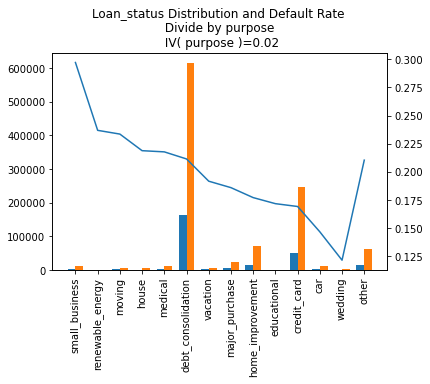

In [20]:
feature="purpose"

my_type = pd.CategoricalDtype(
    categories=['small_business', 'renewable_energy', 'moving', 'house', 'medical','debt_consolidation', 'vacation', 'major_purchase','home_improvement', 'educational', 'credit_card', 'car', 'wedding', 'other'],ordered=True)
eda.data[feature]=eda.data[feature].astype(my_type)

pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=90)
print(pivot)
plot.show()

## 5.1.6.emp_title_bucket

"Driver", "Owner", and "Sales" are the top there employment title in the default rank.

                       count            Calculate Field
                          id                         id
loan_status      Charged Off Fully Paid    Default Rate
emp_title_bucket                                       
Driver                  2116       5442            0.28
Owner                   2696       7606            0.26
Sales                   1701       5786            0.23
Supervisor              1812       6477            0.22
Manager                 4090      15380            0.21
Office Manager          1054       4472            0.19
Registered Nurse        1673       7101            0.19
RN                      1613       6909            0.19
Teacher                 3950      17318            0.19
Project Manager         1034       5347            0.16
Other                 246820     994913            0.20


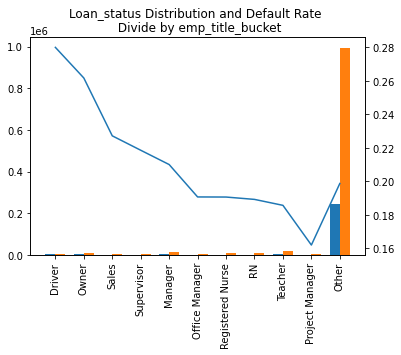

In [21]:
feature="emp_title_bucket"

my_type = pd.CategoricalDtype(
    categories=['Driver', 'Owner', 'Sales', 'Supervisor', 'Manager',
       'Office Manager', 'Registered Nurse', 'RN', 'Teacher',
       'Project Manager', 'Other'],ordered=True)
eda.data[feature]=eda.data[feature].astype(my_type)

pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=90)
print(pivot)
plot.show()

## 5.2.Continuous Variables

### 5.2.1.int_rate

Higher interest rate of the loan can lead to higher default rate.

                                count            Calculate Field
                                   id                         id
loan_status               Charged Off Fully Paid    Default Rate
int_rate_bucket                                                 
(5.308999999999999, 7.39]        6656     128826            0.05
(7.39, 8.9]                     11550     124388            0.08
(8.9, 10.49]                    16739     121115            0.12
(10.49, 11.53]                  20885     114016            0.15
(11.53, 12.74]                  22777     109459            0.17
(12.74, 13.98]                  26600     105169            0.20
(13.98, 15.22]                  31409     103096            0.23
(15.22, 16.99]                  37169     101461            0.27
(16.99, 19.52]                  43141      92288            0.32
(19.52, 30.99]                  51633      76933            0.40


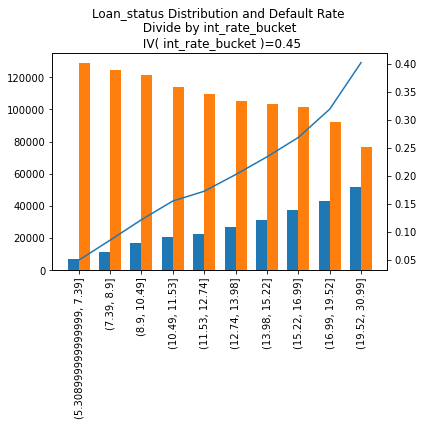

In [22]:
feature="int_rate"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=90)
print(pivot)
plot.show()

### 5.2.2.FICO Score

Borrowers with Higher FICO score has lower default rate.

                        count            Calculate Field
                           id                         id
loan_status       Charged Off Fully Paid    Default Rate
Fico_Score_bucket                                       
(626.999, 667.0]        62456     175229            0.26
(667.0, 672.0]          28848      88354            0.25
(672.0, 677.0]          24872      79721            0.24
(677.0, 682.0]          23860      79480            0.23
(682.0, 692.0]          37836     141050            0.21
(692.0, 697.0]          15762      63338            0.20
(697.0, 707.0]          25235     112926            0.18
(707.0, 722.0]          23698     127950            0.16
(722.0, 742.0]          14534      96280            0.13
(742.0, 847.5]          11458     112423            0.09


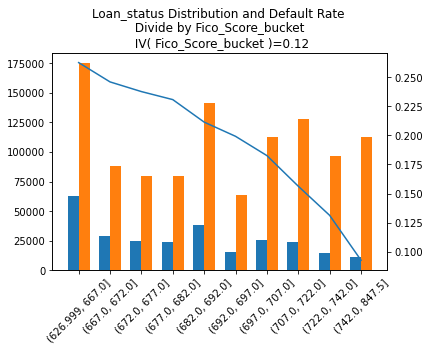

In [23]:
#Combine fico_range_high and fico_range_low
eda.data["Fico_Score"]=(eda.data["fico_range_high"]+eda.data["fico_range_low"])/2
feature="Fico_Score"

pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",iv_feature="fico_range_high",rotation=45)
print(pivot)
plot.show()

### 5.2.3.dti

Borrowers with higher dti has higher default rate.

                     count            Calculate Field
                        id                         id
loan_status    Charged Off Fully Paid    Default Rate
dti_bucket                                           
(-1.001, 7.27]       19733     114940            0.15
(7.27, 10.49]        20550     114144            0.15
(10.49, 13.02]       21841     112740            0.16
(13.02, 15.32]       23214     110909            0.17
(15.32, 17.61]       24838     109575            0.18
(17.61, 19.98]       26528     108083            0.20
(19.98, 22.6]        28403     106318            0.21
(22.6, 25.69]        30680     103684            0.23
(25.69, 29.78]       33734     100714            0.25
(29.78, 999.0]       38967      95341            0.29


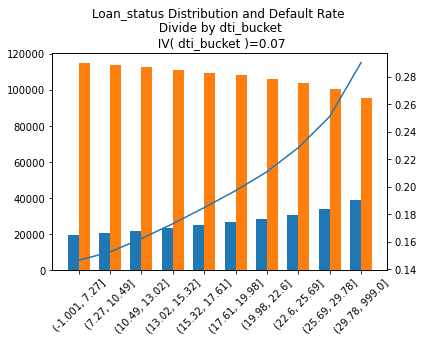

In [24]:
feature="dti"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=45)
print(pivot)
plot.show()

### 5.2.4.mort_acc

Borrower with multiple mortgage account has lower default rate.

                      count            Calculate Field
                         id                         id
loan_status     Charged Off Fully Paid    Default Rate
mort_acc_bucket                                       
(-0.001, 1.0]        169732     580240            0.23
(1.0, 2.0]            34604     154337            0.18
(2.0, 3.0]            23724     115657            0.17
(3.0, 4.0]            15242      79678            0.16
(4.0, 51.0]           18371     106444            0.15


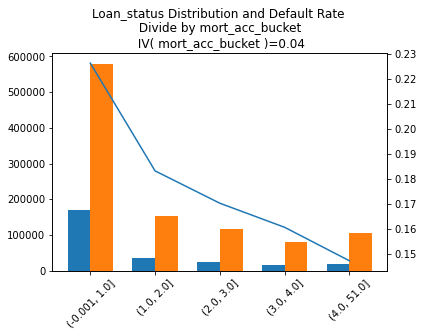

In [25]:
feature="mort_acc"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=45)
print(pivot)
plot.show()

### 5.2.5.Loan_amnt

Borrowers with Higher loan amount has higher default rate.

                         count            Calculate Field
                            id                         id
loan_status        Charged Off Fully Paid    Default Rate
loan_amnt_bucket                                         
(499.999, 5000.0]        28699     153306            0.16
(5000.0, 6500.0]         14125      74751            0.16
(6500.0, 8700.0]         22468     110642            0.17
(8700.0, 10000.0]        27679     123876            0.18
(10000.0, 12000.0]       26313     102236            0.20
(12000.0, 15000.0]       32617     122607            0.21
(15000.0, 18000.0]       26064      88572            0.23
(18000.0, 21000.0]       28354      96746            0.23
(21000.0, 28000.0]       33041     113915            0.22
(28000.0, 40000.0]       29199      90100            0.24


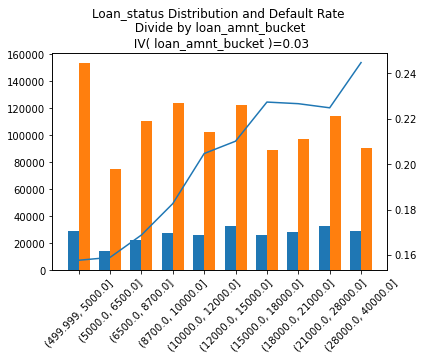

In [26]:
feature="loan_amnt"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=45)
print(pivot)
plot.show()

### 5.2.6.installment

Borrowers with Higher installment has higher default rate.

                                  count            Calculate Field
                                     id                         id
loan_status                 Charged Off Fully Paid    Default Rate
installment_bucket                                                
(4.928999999999999, 157.59]       19237     115645            0.14
(157.59, 216.83]                  21829     112467            0.16
(216.83, 273.3]                   24789     109718            0.18
(273.3, 324.61]                   26293     108199            0.20
(324.61, 375.43]                  29300     106793            0.22
(375.43, 451.73]                  28942     104859            0.22
(451.73, 526.76]                  28386     105265            0.21
(526.76, 640.65]                  30246     104282            0.22
(640.65, 807.92]                  28724     105806            0.21
(807.92, 1719.83]                 30813     103717            0.23


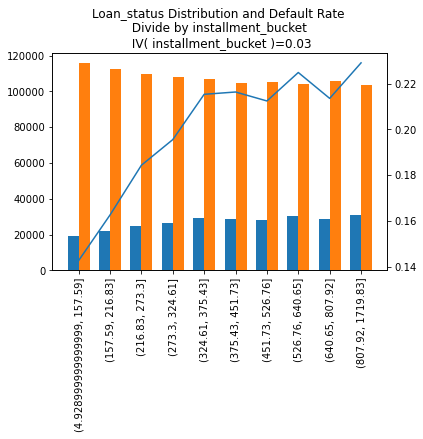

In [27]:
feature="installment"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=90)
print(pivot)
plot.show()

### 5.2.7.annual_inc

Borrowers with higher annual income has lower default rate.

                             count            Calculate Field
                                id                         id
loan_status            Charged Off Fully Paid    Default Rate
annual_inc_bucket                                            
(-0.001, 34000.0]            32675     103169            0.24
(34000.0, 42000.0]           31911     107348            0.23
(42000.0, 50000.0]           34598     123308            0.22
(50000.0, 57000.0]           23352      87084            0.21
(57000.0, 65000.0]           32307     122886            0.21
(65000.0, 74000.0]           21563      88435            0.20
(74000.0, 85000.0]           29046     123468            0.19
(85000.0, 100000.0]          23798     110321            0.18
(100000.0, 125000.0]         19409      98765            0.16
(125000.0, 10999200.0]       19900     111967            0.15


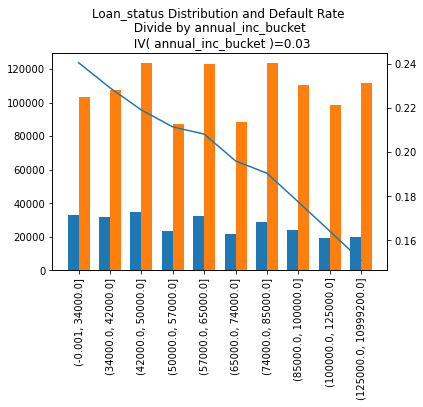

In [28]:
feature="annual_inc"
pivot,plot=eda.visualization_classfied_default_rate(feature,'loan_status',"id","count","Charged Off","Fully Paid",rotation=90)
print(pivot)
plot.show()

## 5.3.Spatial Analysis

### 5.3.1.Default Rate

The top three states by default rate are:"MS", "NE", and "AR".
    
On the map as a whole, the southeastern United States has higher default rates

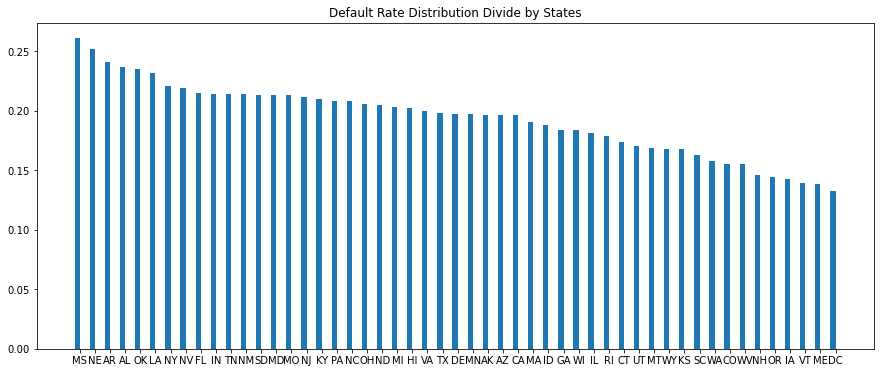

In [29]:
pivot=eda.analysis_pivot(index=['addr_state'], columns=['loan_status'], values=["id"],aggfunc=['count'])
pivot.loc[:,('Calculate Field','id','Default Rate')]= pivot.loc[:, ('count', 'id', 'Charged Off')] / (pivot.loc[:, ('count', 'id', 'Charged Off')] + pivot.loc[:, ('count', 'id', 'Fully Paid')])
pivot=pivot.sort_values(by=('Calculate Field','id','Default Rate'),ascending=False)

plot=eda.visualization_plot("bar",
                       [pivot.index.values,pivot.loc[:,('Calculate Field','id','Default Rate')],'Default Rate'],
                       figsize=(15,6),
                       title="Default Rate Distribution Divide by States")

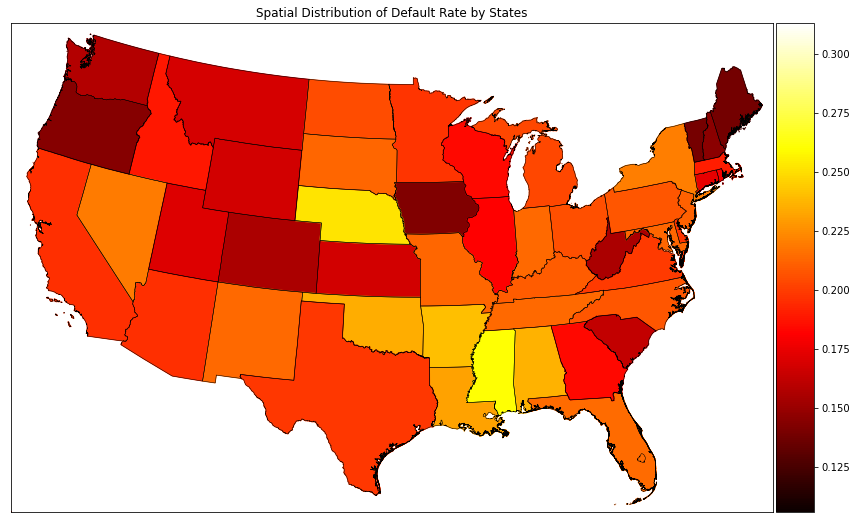

In [30]:
plot=eda.visualization_geo(pivot,('Calculate Field','id','Default Rate'),
                           # map boundary
                           llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                           # shapefile path
                           geo_file_path='s_22mr22',
                           figsize=(16,9),
                           title="Spatial Distribution of Default Rate by States")

### 5.3.2.Total Loan_amt

The top three states by Total loan amount are:"CA", "TX", and "NY".

On the map as a whole, Coastal regions have higher total loan amount than inland regions.

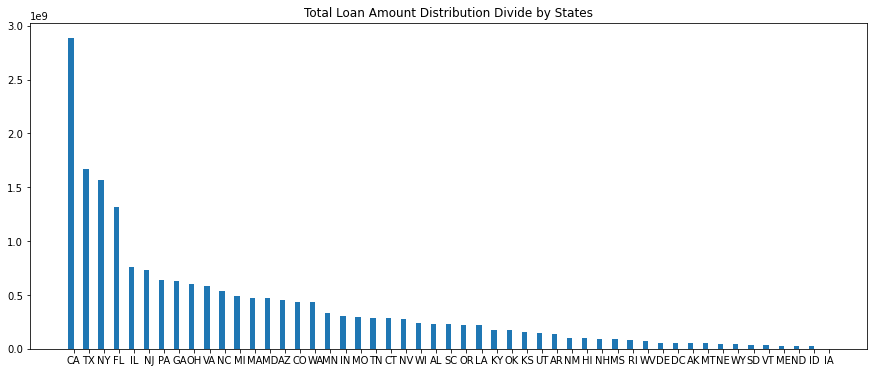

In [31]:
pivot=eda.analysis_pivot(index=['addr_state'], columns=[], values=["loan_amnt"],aggfunc=['sum'])
pivot=pivot.sort_values(by=('sum', 'loan_amnt'),ascending=False)

plot=eda.visualization_plot("bar",
                       [pivot.index.values,pivot.loc[:,('sum', 'loan_amnt')],'total loan amnt'],
                       figsize=(15,6),
                       title="Total Loan Amount Distribution Divide by States")

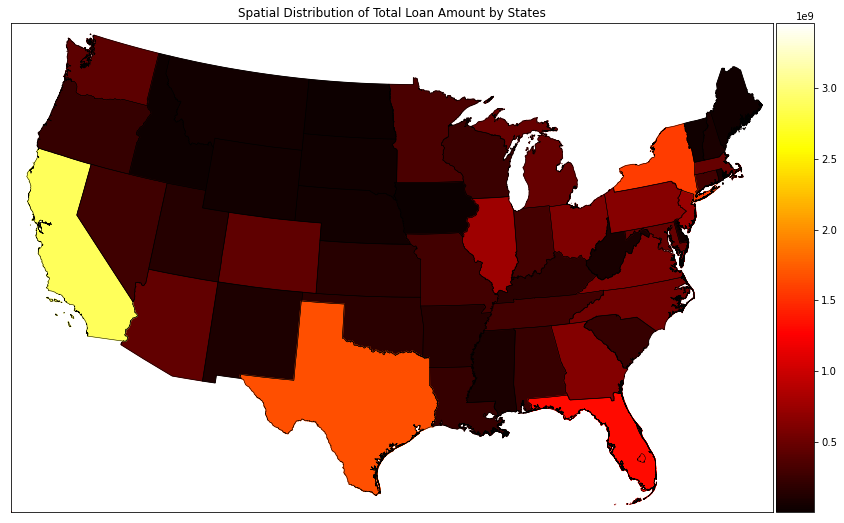

In [32]:
plot=eda.visualization_geo(pivot,('sum', 'loan_amnt'),
                           # map boundary
                           llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                           # shapefile path
                           geo_file_path='s_22mr22',
                           figsize=(16,9),
                           title="Spatial Distribution of Total Loan Amount by States")

## 5.3.3. Average Loan_amnt

The average loan amount in AK is higher than other states.

The average loan amount in IA is lower than other states.

Aside from AK and IA, the average loan amount of other states are at around the same level.

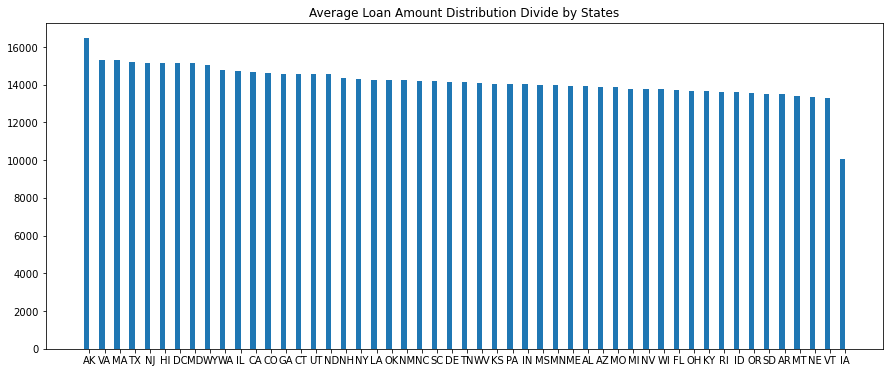

In [33]:
pivot=eda.analysis_pivot(index=['addr_state'], columns=[], values=["loan_amnt"],aggfunc=['sum','count'])
pivot.loc[:,('Calculate Field','avg_loan_amnt')]= pivot.loc[:, (  'sum', 'loan_amnt')] / pivot.loc[:, ('count', 'loan_amnt')] 
pivot=pivot.sort_values(by=('Calculate Field','avg_loan_amnt'),ascending=False)


plot=eda.visualization_plot("bar",
                       [pivot.index.values,pivot.loc[:,('Calculate Field','avg_loan_amnt')],'average loan amnt'],
                       figsize=(15,6),
                       title="Average Loan Amount Distribution Divide by States")

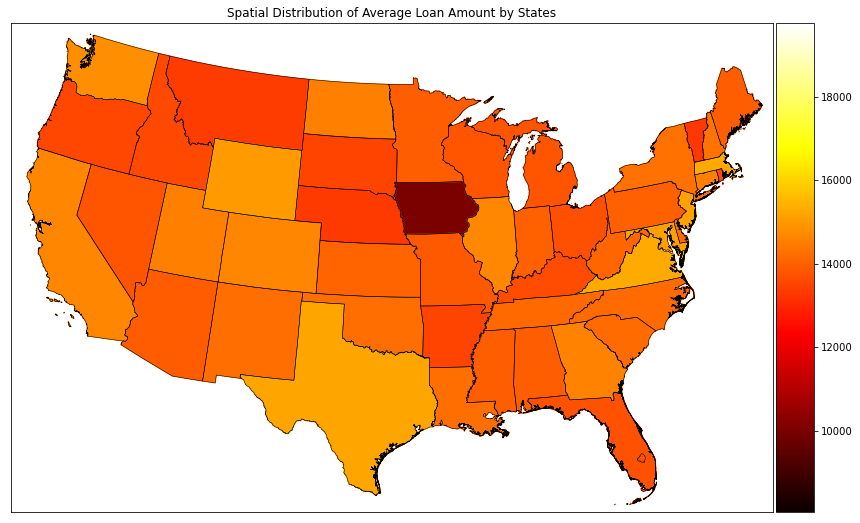

In [34]:
plot=eda.visualization_geo(pivot,('Calculate Field','avg_loan_amnt'),
                           # map boundary
                           llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                           # shapefile path
                           geo_file_path='s_22mr22',
                           figsize=(16,9),
                           title="Spatial Distribution of Average Loan Amount by States")

# 6. Conclusion

1. In this analysis, I focus on the risk of loan based on the accepted data. The overall default rate in closed case are 20%.

2. Based on the year that issue the loan to group the cases, from 2009 to 2017, default rate keep increasing. The default rate of 2018 is significantly low than the previous year. This may be explained that there are a little part of closed case at the time of getting the data.

3. The grade and subgrade of the loan have a significant negative correlation with default rates. The higher the loan grade, the lower the default rate.

4. Lending Club offers borrowers two repayment cycle options, 36 months and 60 months. The default rate for a 60-month(32%) loan is double that of a 36-month loan(16%).

5. Income-verified borrowers have a higher default rate than unverified borrowers.

6. There are three main type of home ownership:'MORTGAGE','OWN',and 'RENT'. The default rate of borrowers with the home ownership of mortgage is the lowest(17%).

7. Borrowers have two main borrowing purposes, paying off debt and paying off credit cards. The default rate of borrowings for the purpose of repaying debts is higher than that for borrowings for the purpose of repaying credit cards.

8. The higher the repayment difficulty of the loan itself, the higher the default rate. Such as higher loan amount, higher interest rate, more monthly installment. In contrast, the higher the repayment ability or credit level of the borrower itself, the lower the default rate. Such as higher FICO score, higher annual income.

9. The top three states by default rate are: Mississippi, Nebraska, and Arkansas. Looking at the map as a whole, borrowers located in the southeastern United States have higher default rates.

10. From the perspective of total borrowing amount, the top three states are: California, Texas, and New York. From the overall map, the main business of lending club is concentrated in the coastal areas and Texas.